In [1]:
%cd "~/moses-incons-pen-xp"
%load_ext autoreload
%autoreload 2

/home/xabush/moses-incons-pen-xp


In [2]:
import numpy as np
import pandas as pd
import scipy
import math
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score
import math
from sklearn.model_selection import train_test_split
from datetime import datetime
from notebooks.manifold_reg.util import *

In [3]:
X, beta, y_log = generate_log_data(200, 10, tf_on=4, val_tf=[5, 5, 5, 5], n=200)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.5, stratify=y_log)

In [5]:
assoc_mat = get_assoc_mat(200, 10)

In [20]:
prec_mat = get_emp_covariance(X_train, assoc_mat)
L_mat_norm = get_laplacian_mat(X_train, X_train, prec_mat, 0.1, True)
L_mat = get_laplacian_mat(X_train, X_train, prec_mat, 0.1, False)

In [103]:
from notebooks.manifold_reg.log_util import log_msg

def beta_noise_pen(gammas, assoc_mat, n_sim=10, n_var=50):

    variance_r = np.logspace(0, 2, n_var)
    variance_r = np.concatenate([np.array([0]), variance_r])
    # beta_vals = np.zeros((len(gammas), n_sim + 1, beta.shape[0]))
    pen_vals_norm = np.zeros((n_sim, len(gammas),  n_var + 1))
    pen_vals_unorm = np.zeros((n_sim, len(gammas), n_var  + 1))

    for i in range(n_sim):
        log_msg(f"Sim {i + 1}...")
        X, beta, _ = generate_log_data(200, 10, tf_on=4, val_tf=[5, 5, 5, 5], n=100)
        prec_mat = get_emp_covariance(X, assoc_mat)

        for j, g in enumerate(gammas):
            L_mat_norm = get_laplacian_mat(X, X, prec_mat, g, True)
            L_mat = get_laplacian_mat(X, X, prec_mat, g, False)
            f = X @ beta
            pen_norm = f.T @ L_mat_norm @ f
            pen_unorm = f.T @ L_mat @ f
            pen_vals_norm[i, j, 0] = pen_norm
            pen_vals_unorm[i, j, 0] = pen_unorm

            for k in range(1, n_var + 1):
                b_noise = np.random.normal(loc=0.0, scale=np.sqrt(variance_r[k]), size=beta.shape[0])
                beta_new = beta + b_noise
                # beta_vals[i, j] = beta_new
                f = X @ beta_new
                pen_norm = f.T @ L_mat_norm @ f
                pen_unorm = f.T @ L_mat @ f

                pen_vals_norm[i, j, k] = pen_norm
                pen_vals_unorm[i, j, k] = pen_unorm

    pen_vals_norm_mean = np.mean(pen_vals_norm, axis=0)
    pen_vals_unorm_mean = np.mean(pen_vals_unorm, axis=0)

    log_msg("Done")
    return variance_r,pen_vals_norm_mean, pen_vals_unorm_mean

def f_noise_pen(gammas, assoc_mat, n_sim=10, n_var=50):

    variance_r = np.logspace(0, 2, n_var)
    variance_r = np.concatenate([np.array([0]), variance_r])
    # beta_vals = np.zeros((len(gammas), n_sim + 1, beta.shape[0]))
    pen_vals_norm = np.zeros((n_sim, len(gammas), n_var + 1))
    pen_vals_unorm = np.zeros((n_sim, len(gammas),n_var  + 1))

    for i in range(n_sim):
        log_msg(f"Sim {i + 1}...")
        X, beta, _ = generate_log_data(200, 10, tf_on=4, val_tf=[5, 5, 5, 5], n=100)
        prec_mat = get_emp_covariance(X, assoc_mat)

        f = X @ beta

        for j, g in enumerate(gammas):
            L_mat_norm = get_laplacian_mat(X, X, prec_mat, g, True)
            L_mat = get_laplacian_mat(X, X, prec_mat, g, False)
            pen_norm = f.T @ L_mat_norm @ f
            pen_unorm = f.T @ L_mat @ f
            pen_vals_norm[i, j, 0] = pen_norm
            pen_vals_unorm[i, j, 0] = pen_unorm

            for k in range(1, n_var + 1):
                f_noise = np.random.normal(loc=np.zeros(f.shape[0]), scale=np.sqrt(variance_r[k]), size=f.shape[0])
                f_new = f + f_noise
                pen_norm = f_new.T @ L_mat_norm @ f_new
                pen_unorm = f_new.T @ L_mat @ f_new

                pen_vals_norm[i, j, k] = pen_norm
                pen_vals_unorm[i, j, k] = pen_unorm

    log_msg("Done.")
    pen_vals_norm_mean = np.mean(pen_vals_norm, axis=0)
    pen_vals_unorm_mean = np.mean(pen_vals_unorm, axis=0)

    return variance_r, pen_vals_norm_mean, pen_vals_unorm_mean

In [96]:
gammas = np.logspace(-1, 3, 6)

In [97]:

variance_r, pen_vals_norm, pen_vals_unorm = beta_noise_pen(gammas, assoc_mat)

Sim 1...
Sim 2...
Sim 3...
Sim 4...
Sim 5...
Sim 6...
Sim 7...
Sim 8...
Sim 9...
Sim 10...
Done


In [98]:
pen_vals_unorm

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.64713851e-06, 1.12843178e-05, 1.21012964e-05, 1.16281968e-05,
       

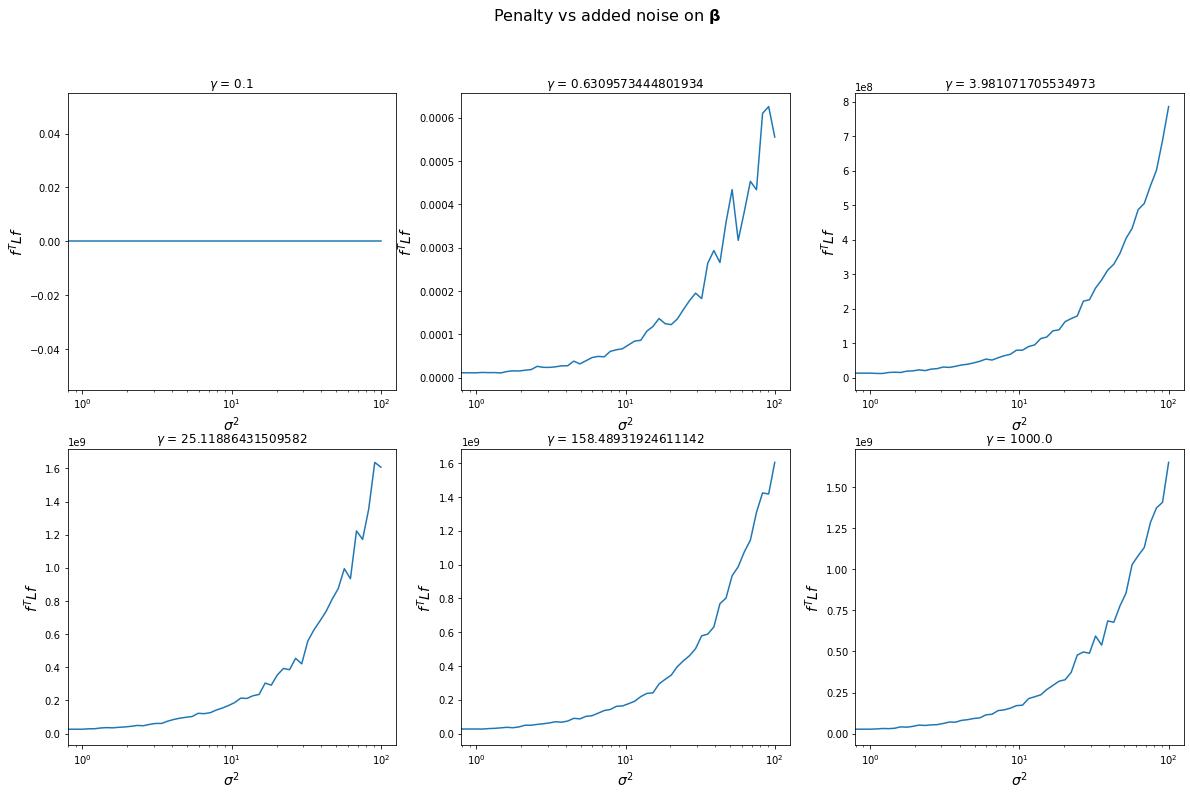

In [99]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 12))

fig.suptitle(r"Penalty vs added noise on $\mathbf{\beta}$", fontsize=16)

k = 0

for i in range(2):
    for j in range(3):
        idx = j + k
        ax[i, j].plot(variance_r, pen_vals_unorm[idx])
        ax[i, j].set_xlabel(r"$\sigma^{2}$", fontsize=14)
        ax[i, j].set_ylabel(r"$f^{T}Lf$", fontsize=14)
        ax[i, j].set_xscale("log")
        ax[i, j].set_title(f"$\gamma$ = {gammas[idx]}")
        # ax[0].legend()
    k += 3

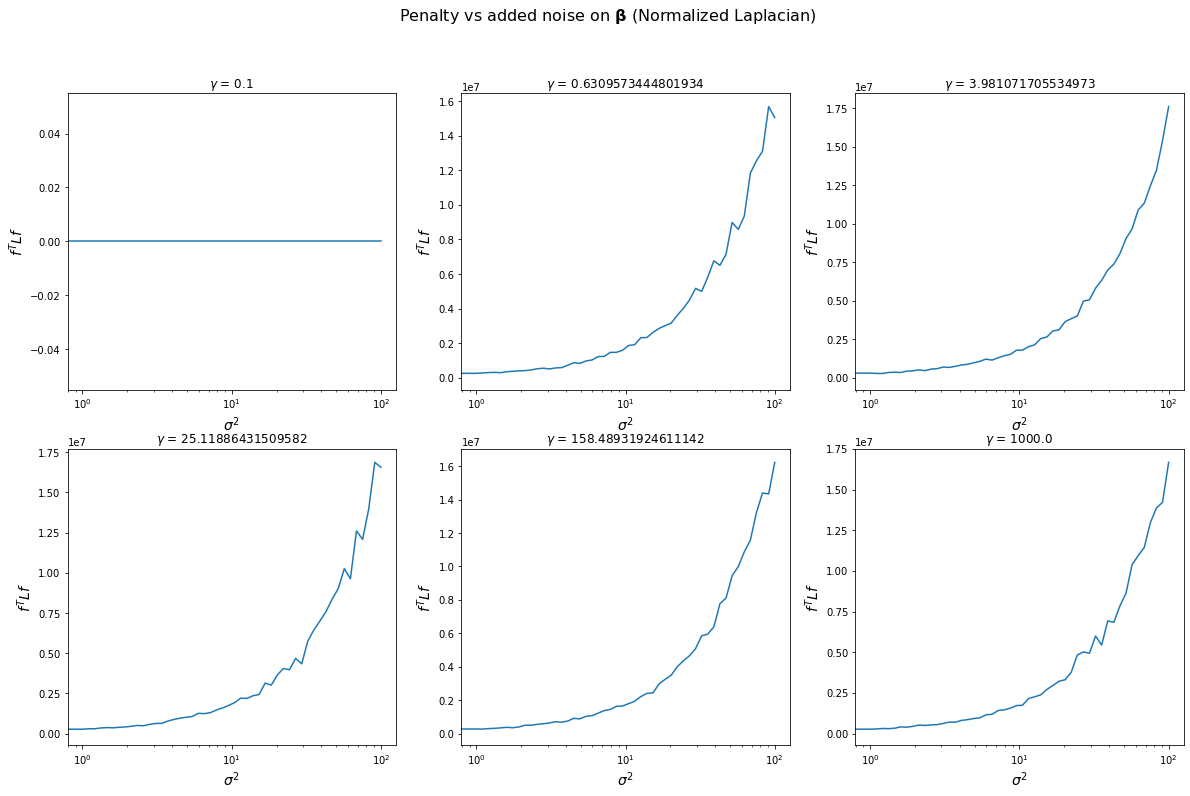

In [100]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 12))

fig.suptitle(r"Penalty vs added noise on $\mathbf{\beta}$ (Normalized Laplacian)", fontsize=16)

k = 0

for i in range(2):
    for j in range(3):
        idx = j + k
        ax[i, j].plot(variance_r, pen_vals_norm[idx])
        ax[i, j].set_xlabel(r"$\sigma^{2}$", fontsize=14)
        ax[i, j].set_ylabel(r"$f^{T}Lf$", fontsize=14)
        ax[i, j].set_xscale("log")
        ax[i, j].set_title(f"$\gamma$ = {gammas[idx]}")
        # ax[0].legend()
    k += 3

In [104]:
variance_r_f, pen_vals_norm_f, pen_vals_unorm_f = f_noise_pen(gammas, assoc_mat)

Sim 1...
Sim 2...
Sim 3...
Sim 4...
Sim 5...
Sim 6...
Sim 7...
Sim 8...
Sim 9...
Sim 10...
Done.


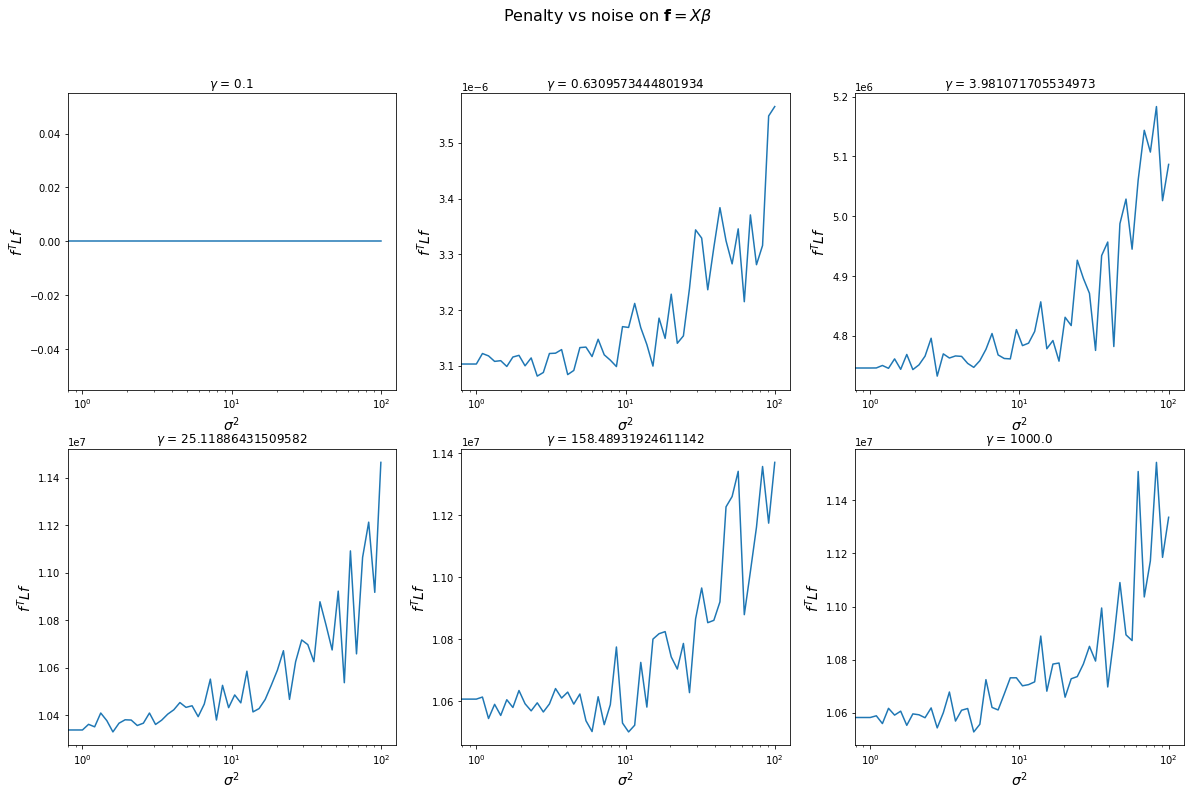

In [105]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 12))

fig.suptitle(r"Penalty vs noise on $\mathbf{f} = X\beta$ ", fontsize=16)

k = 0

for i in range(2):
    for j in range(3):
        idx = j + k
        ax[i, j].plot(variance_r_f, pen_vals_unorm_f[idx])
        ax[i, j].set_xlabel(r"$\sigma^{2}$", fontsize=14)
        ax[i, j].set_ylabel(r"$f^{T}Lf$", fontsize=14)
        ax[i, j].set_xscale("log")
        ax[i, j].set_title(f"$\gamma$ = {gammas[idx]}")
        # ax[0].legend()
    k += 3

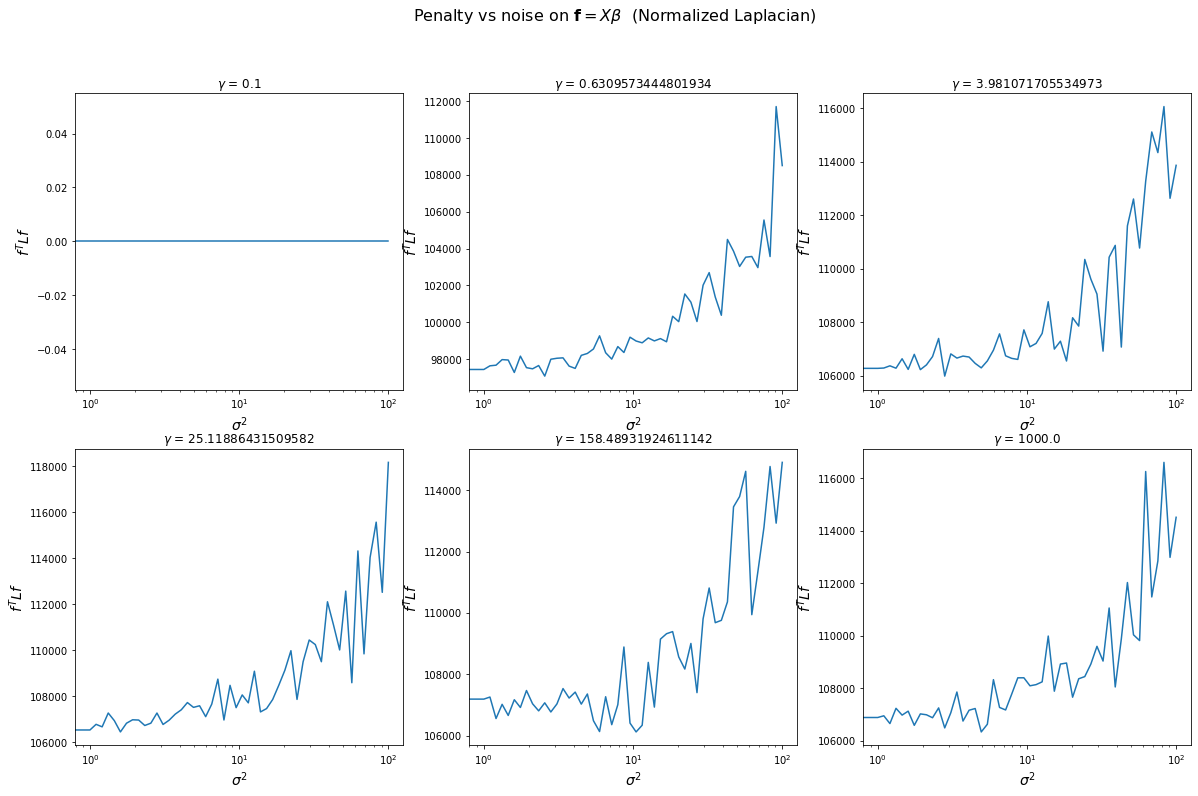

In [106]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 12))

fig.suptitle(r"Penalty vs noise on $\mathbf{f} = X\beta$  (Normalized Laplacian)", fontsize=16)

k = 0

for i in range(2):
    for j in range(3):
        idx = j + k
        ax[i, j].plot(variance_r_f, pen_vals_norm_f[idx])
        ax[i, j].set_xlabel(r"$\sigma^{2}$", fontsize=14)
        ax[i, j].set_ylabel(r"$f^{T}Lf$", fontsize=14)
        ax[i, j].set_xscale("log")
        ax[i, j].set_title(f"$\gamma$ = {gammas[idx]}")
        # ax[0].legend()
    k += 3